In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten, Input
from tensorflow.keras.models import Model
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from tabnet_keras import TabNetRegressor, TabNetClassifier





In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from config.config import *
# from libs.common import *

c:\Users\PC\Data\ads_fraud_detection
c:/Users/PC/Data/ads_fraud_detection


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print('Using GPU:', gpus[0])  # In ra tên của GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
else:
    print('No GPU found. Using CPU.')

In [2]:
save_dir=f"{exps_dir}/exp1/exp_base"
if os.path.exists(save_dir) == False: 
  os.makedirs(save_dir, exist_ok=True)



test_size=0.33
seed=42

In [3]:
# feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
# feature_selection = {key: value for key, value in feature_selection.item().items()}
# feature_selection

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [4]:
# bg_model=joblib.load(f'{save_dir}/bg_model.joblib')
# rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
# svm_model=joblib.load(f'{save_dir}/svm_model.joblib')

In [5]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 0.6555772994129159, 1: 2.106918238993711}

In [6]:


# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse=False)
    
    labels_reshaped = labels.reshape(-1, 1)
    
    encoder.fit(labels_reshaped)
    
    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(330, 2) (670, 2)


In [7]:
y_test_onehot.reshape(-1, 1)
print(y_test_onehot.shape)

(330, 2)


In [8]:
x_test.shape

(330, 39)

In [9]:
x_train.shape

(670, 39)

In [10]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    y_pred = K.round(y_pred)    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)    
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())    
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())    
    macro_f1_score = K.mean(f1_scores)
    
    return macro_f1_score

In [11]:
print(x_train.shape[1])

39


#### * Xây dựng model:

#### * Xây dựng Stacked_model:

In [12]:
def f1_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate true positives, predicted positives, and possible positives for each class
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    possible_positives = tf.reduce_sum(y_true, axis=0)
    
    # Calculate precision and recall for each class
    precision = tp / (predicted_positives + tf.keras.backend.epsilon())
    recall = tp / (possible_positives + tf.keras.backend.epsilon())
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    # Calculate the macro F1 score
    f1_macro = tf.reduce_mean(f1)
    
    # Return the F1 loss
    return 1 - f1_macro

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [14]:
input_shape =(42,1)
x_input = Input(shape=input_shape)
dense_units = 1024
learning_rate = 0.0001
kernel_size =3
filter_size=128

def VGG19():
    # Determine proper input shape
    input_shape =(39,1)
    x_input = Input(shape=input_shape)

    # Block 1
    x = Conv1D(filter_size*2, 3, activation='relu', padding='same', name='block1_conv1')(x_input)
    x = Conv1D(filter_size*2, 3, activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling1D(2, strides=2, name='block1_pool')(x)

    # Block 2
    x = Conv1D(filter_size*4, 3, activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv1D(filter_size*4, 3, activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling1D(2, strides=2, name='block2_pool')(x)

    # Block 3
    x = Conv1D(filter_size*6, 3, activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv1D(filter_size*6, 3, activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv1D(filter_size*6, 3, activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv1D(filter_size*6, 3, activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling1D(2, strides=2, name='block3_pool')(x)

    # Block 4
    x = Conv1D(filter_size*8, 3, activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv1D(filter_size*8, 3, activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv1D(filter_size*8, 3, activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv1D(filter_size*8, 3, activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling1D(2, strides=2, name='block4_pool')(x)

    # Block 5
    x = Conv1D(filter_size*8, 3, activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv1D(filter_size*8, 3, activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv1D(filter_size*8, 3, activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv1D(filter_size*8, 3, activation='relu', padding='same', name='block5_conv4')(x)

    x = MaxPooling1D(2, strides=2, name='block5_pool')(x)
    
    # x = Flatten(name='flatten')(x)
    # x = Dense(4096, activation='relu', name='fc1')(x)
    # x = Dense(4096, activation='relu', name='fc2')(x)
    # x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

    x = GlobalAveragePooling1D()(x)
    #x = GlobalMaxPooling1D()(x)
    x = Dense(2, activation='softmax', name='predictions')(x)  # Sigmoid for binary classification

    # Create model.
    model = Model(x_input, x, name='vgg19')
    return model
model = VGG19()
# lr=0.0001
# model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=['accuracy',f1_score])
early_stopping = EarlyStopping(monitor='val_accuracy',
    # min_delta=0.00005,
    patience=60,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.95,
    patience=10,
    min_lr=0.000001,
    verbose=1,
)

In [15]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 39, 1)]           0         
                                                                 
 block1_conv1 (Conv1D)       (None, 39, 256)           1024      
                                                                 
 block1_conv2 (Conv1D)       (None, 39, 256)           196864    
                                                                 
 block1_pool (MaxPooling1D)  (None, 19, 256)           0         
                                                                 
 block2_conv1 (Conv1D)       (None, 19, 512)           393728    
                                                                 
 block2_conv2 (Conv1D)       (None, 19, 512)           786944    
                                                                 
 block2_pool (MaxPooling1D)  (None, 9, 512)            0     

In [16]:
class_weights_dict

{0: 0.6555772994129159, 1: 2.106918238993711}

In [17]:
model.fit(x=x_train, y=y_train_onehot,
          validation_data=(x_test, y_test_onehot),
          batch_size=32,
          epochs=1200,
          callbacks=[early_stopping, lr_scheduler])

Epoch 1/1200
21/21 [==============================] - 20s 744ms/step - loss: 0.6036 - accuracy: 0.7627 - f1_score: 0.4319 - val_loss: 0.7766 - val_accuracy: 0.7333 - val_f1_score: 0.4193 - lr: 1.0000e-04
Epoch 2/1200
21/21 [==============================] - 14s 686ms/step - loss: 0.5642 - accuracy: 0.7627 - f1_score: 0.4320 - val_loss: 0.5823 - val_accuracy: 0.7333 - val_f1_score: 0.4193 - lr: 1.0000e-04
Epoch 3/1200
21/21 [==============================] - 14s 675ms/step - loss: 0.5494 - accuracy: 0.7627 - f1_score: 0.4321 - val_loss: 0.6017 - val_accuracy: 0.7333 - val_f1_score: 0.4193 - lr: 1.0000e-04
Epoch 4/1200
21/21 [==============================] - 14s 662ms/step - loss: 0.5435 - accuracy: 0.7627 - f1_score: 0.4310 - val_loss: 0.5765 - val_accuracy: 0.7333 - val_f1_score: 0.4193 - lr: 1.0000e-04
Epoch 5/1200
21/21 [==============================] - 15s 698ms/step - loss: 0.5529 - accuracy: 0.7627 - f1_score: 0.4314 - val_loss: 0.5702 - val_accuracy: 0.7333 - val_f1_score: 0.41

In [18]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 39, 1)]           0         
                                                                 
 block1_conv1 (Conv1D)       (None, 39, 256)           1024      
                                                                 
 block1_conv2 (Conv1D)       (None, 39, 256)           196864    
                                                                 
 block1_pool (MaxPooling1D)  (None, 19, 256)           0         
                                                                 
 block2_conv1 (Conv1D)       (None, 19, 512)           393728    
                                                                 
 block2_conv2 (Conv1D)       (None, 19, 512)           786944    
                                                                 
 block2_pool (MaxPooling1D)  (None, 9, 512)            0     

#### * Kết quả đánh giá mô hình:

In [19]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 39, 1)]           0         
                                                                 
 block1_conv1 (Conv1D)       (None, 39, 256)           1024      
                                                                 
 block1_conv2 (Conv1D)       (None, 39, 256)           196864    
                                                                 
 block1_pool (MaxPooling1D)  (None, 19, 256)           0         
                                                                 
 block2_conv1 (Conv1D)       (None, 19, 512)           393728    
                                                                 
 block2_conv2 (Conv1D)       (None, 19, 512)           786944    
                                                                 
 block2_pool (MaxPooling1D)  (None, 9, 512)            0     

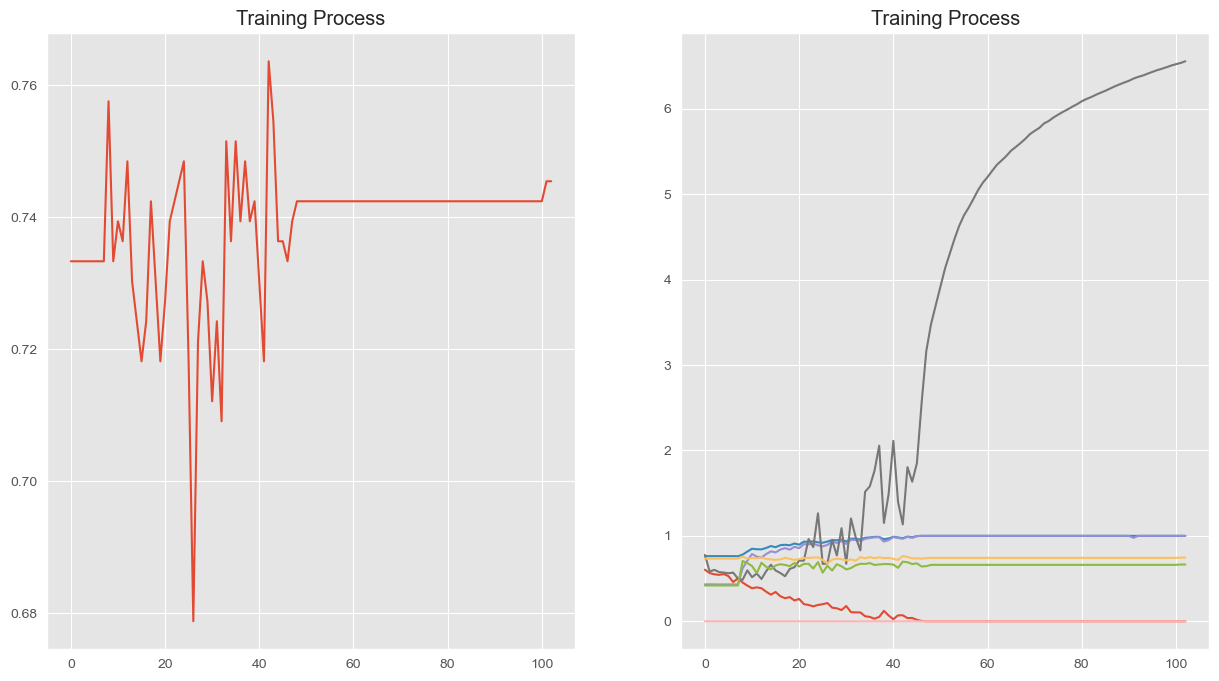

<Figure size 640x480 with 0 Axes>

In [20]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')
axes[1].plot(pd.DataFrame(history))
axes[1].set_title('Training Process')
plt.show()
plt.savefig('train.png')

In [21]:
y_test_labels = np.argmax(y_test_onehot, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test_labels, predictions)
accuracy


11/11 [==============================] - 0s 31ms/step


0.7636363636363637

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

y_test_labels = np.argmax(y_test_onehot, axis=1)

accuracy = accuracy_score(y_test_labels, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test_labels, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, predictions))


Accuracy: 0.7636363636363637
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       242
           1       0.56      0.57      0.56        88

    accuracy                           0.76       330
   macro avg       0.70      0.70      0.70       330
weighted avg       0.77      0.76      0.76       330

Confusion Matrix:
[[202  40]
 [ 38  50]]


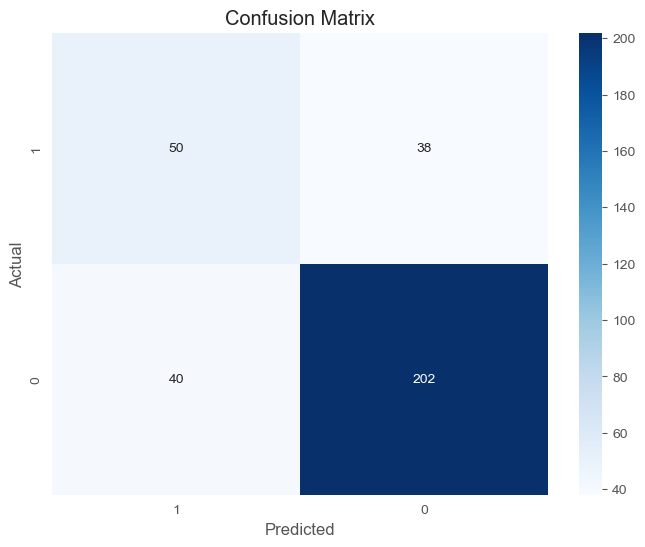

In [23]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

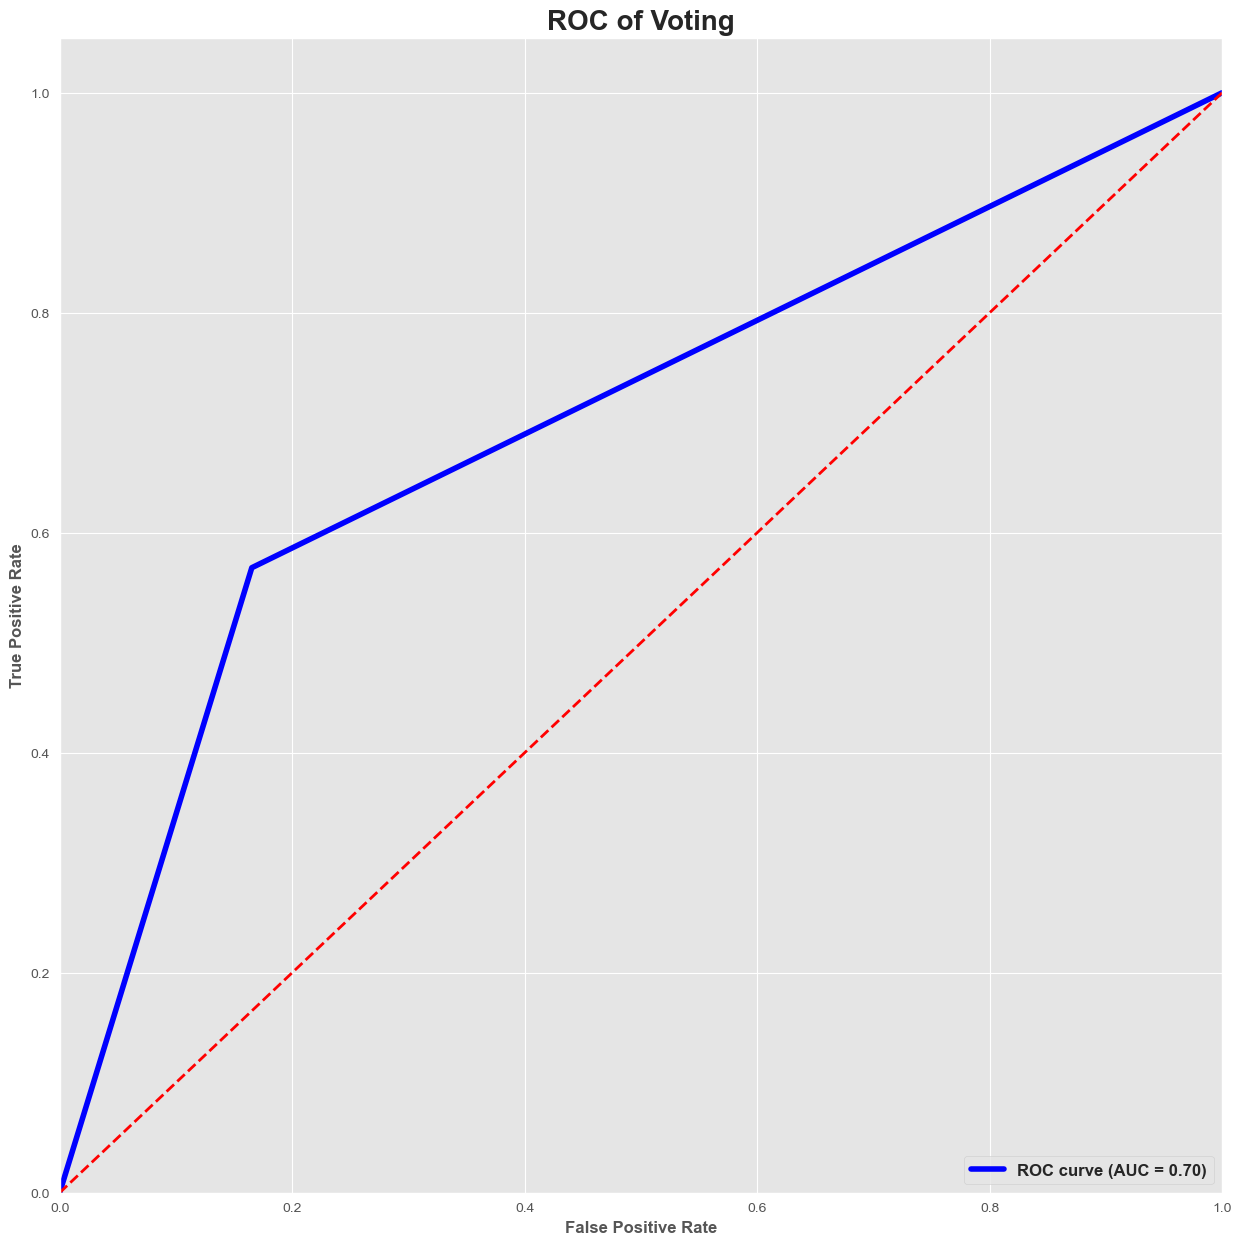

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, predictions)
    
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')  
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'}) 
plt.show()

In [25]:
def check_result(prediction):
    prediction = (prediction > 0.2).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [26]:
# solandung=0
# hopdonggianlan=0
# for indx in range(len(x_test)):
#     y_predict = stacked_model.predict(stacked_input)
#     stacked_pred_labels = y_predict.argmax(axis=1)

#     #print(y_predict[0][0])
#     Y_check = check_result(y_test.iloc[indx])
#     print('True:', Y_check)
#     print('Predicted:', check_result(stacked_pred_labels[indx]))
#     print("----------------------------")
#     if Y_check==check_result(stacked_pred_labels[indx]):
#         solandung+=1
#         if Y_check=='Y':
#             hopdonggianlan+=1
    

In [27]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


NameError: name 'solandung' is not defined